In [1]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

напишем упрощенную версию TAM (извлекает активации из сверточных слоев и создает карты активации) и для сравнения простую CNN, будем сегментировать медицинские изображения

In [2]:
class SimpleTAM:
    def __init__(self, model):
        self.model = model
        self.activations = {}

    def register_hooks(self):
        def hook_fn(name):
            def hook(module, input, output):
                self.activations[name] = output.detach()
            return hook

        for name, layer in self.model.named_modules():
            if isinstance(layer, nn.Conv2d):
                layer.register_forward_hook(hook_fn(name))

    def generate_map(self, img, target_layer='conv2'):
        self.activations = {}
        with torch.no_grad():
            output = self.model(img)

        if target_layer not in self.activations:
            target_layer = list(self.activations.keys())[-1]

        activation = self.activations[target_layer]
        weights = torch.mean(activation, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * activation, dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam, output

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class TAMEnhancedCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.attention = nn.Conv2d(64, 64, 1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))

        att = self.sigmoid(self.attention(x))
        x = x * att

        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [3]:
def train_model(epochs=3):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

    model = SimpleCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:
                print(f'Epoch {epoch+1}, Batch {i+1}, Loss: {running_loss/100:.3f}')
                running_loss = 0.0

    return model

def test_tam(model):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=1, shuffle=True)

    tam = SimpleTAM(model)
    tam.register_hooks()

    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    model.eval()
    correct = 0
    total = 0

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    sample_idx = 0

    for images, labels in testloader:
        cam, outputs = tam.generate_map(images)
        _, predicted = torch.max(outputs.data, 1)

        total += 1
        correct += (predicted == labels).sum().item()

        if sample_idx < 3:
            img = images[0].cpu().numpy().transpose(1, 2, 0)
            img = (img * 0.5 + 0.5).clip(0, 1)

            cam_resized = torch.nn.functional.interpolate(
                cam, size=(32, 32), mode='bilinear', align_corners=False
            )[0, 0].cpu().numpy()

            axes[0, sample_idx].imshow(img)
            axes[0, sample_idx].set_title(f'True: {classes[labels[0]]}\nPred: {classes[predicted[0]]}')
            axes[0, sample_idx].axis('off')

            axes[1, sample_idx].imshow(img)
            axes[1, sample_idx].imshow(cam_resized, cmap='jet', alpha=0.5)
            axes[1, sample_idx].set_title('TAM')
            axes[1, sample_idx].axis('off')

            sample_idx += 1

        if total >= 100:
            break

    accuracy = 100 * correct / total

    plt.tight_layout()
    plt.savefig('tam_results.png', dpi=150, bbox_inches='tight')
    plt.close()

    return accuracy


In [4]:
def train_model(model, model_name, epochs=5):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    train_times = []

    start_time = time.time()

    for epoch in range(epochs):
        epoch_loss = 0.0
        epoch_start = time.time()

        for i, (inputs, labels) in enumerate(trainloader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        epoch_time = time.time() - epoch_start
        avg_loss = epoch_loss / len(trainloader)
        train_losses.append(avg_loss)
        train_times.append(epoch_time)

        print(f'{model_name} - Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Time: {epoch_time:.2f}s')

    total_time = time.time() - start_time

    return model, train_losses, total_time

def evaluate_model(model, model_name):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

def visualize_tam(model, model_name):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=1, shuffle=True)

    tam = SimpleTAM(model)
    tam.register_hooks()

    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    model.eval()

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    sample_idx = 0

    for images, labels in testloader:
        if sample_idx >= 4:
            break

        cam, outputs = tam.generate_map(images)
        _, predicted = torch.max(outputs.data, 1)

        img = images[0].cpu().numpy().transpose(1, 2, 0)
        img = (img * 0.5 + 0.5).clip(0, 1)

        cam_resized = torch.nn.functional.interpolate(
            cam, size=(32, 32), mode='bilinear', align_corners=False
        )[0, 0].cpu().numpy()

        axes[0, sample_idx].imshow(img)
        axes[0, sample_idx].set_title(f'True: {classes[labels[0]]}\nPred: {classes[predicted[0]]}')
        axes[0, sample_idx].axis('off')

        axes[1, sample_idx].imshow(img)
        axes[1, sample_idx].imshow(cam_resized, cmap='jet', alpha=0.5)
        axes[1, sample_idx].set_title('TAM Activation')
        axes[1, sample_idx].axis('off')

        sample_idx += 1

    plt.suptitle(f'{model_name} - TAM Visualization', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'tam_{model_name.lower().replace(" ", "_")}.png', dpi=150, bbox_inches='tight')
    plt.close()

def plot_comparison(cnn_losses, tam_losses, cnn_acc, tam_acc, cnn_time, tam_time):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].plot(cnn_losses, label='Simple CNN', marker='o')
    axes[0].plot(tam_losses, label='TAM-Enhanced CNN', marker='s')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Loss Comparison')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    models = ['Simple CNN', 'TAM-Enhanced']
    accuracies = [cnn_acc, tam_acc]
    colors = ['#3498db', '#e74c3c']
    bars = axes[1].bar(models, accuracies, color=colors)
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Test Accuracy Comparison')
    axes[1].set_ylim(0, 100)
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}%', ha='center', va='bottom')

    times = [cnn_time, tam_time]
    bars = axes[2].bar(models, times, color=colors)
    axes[2].set_ylabel('Time (seconds)')
    axes[2].set_title('Training Time Comparison')
    for bar in bars:
        height = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}s', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig('comparison_results.png', dpi=150, bbox_inches='tight')
    plt.close()



In [5]:
print("\n[1/4] Обучение Simple CNN...")
cnn_model = SimpleCNN()
cnn_model, cnn_losses, cnn_time = train_model(cnn_model, "Simple CNN", epochs=5)

print("\n[2/4] Обучение TAM-Enhanced CNN...")
tam_model = TAMEnhancedCNN()
tam_model, tam_losses, tam_time = train_model(tam_model, "TAM-Enhanced CNN", epochs=5)

print("\n[3/4] Тестирование моделей...")
cnn_acc = evaluate_model(cnn_model, "Simple CNN")
tam_acc = evaluate_model(tam_model, "TAM-Enhanced CNN")

print("\n[4/4] Генерация визуализаций...")
visualize_tam(cnn_model, "Simple CNN")
visualize_tam(tam_model, "TAM-Enhanced CNN")
plot_comparison(cnn_losses, tam_losses, cnn_acc, tam_acc, cnn_time, tam_time)

print("\n" + "="*70)
print("РЕЗУЛЬТАТЫ СРАВНЕНИЯ")
print("="*70)
print(f"\nSimple CNN:")
print(f"  - Точность: {cnn_acc:.2f}%")
print(f"  - Время обучения: {cnn_time:.1f}s")
print(f"  - Финальный loss: {cnn_losses[-1]:.4f}")

print(f"\nTAM-Enhanced CNN:")
print(f"  - Точность: {tam_acc:.2f}%")
print(f"  - Время обучения: {tam_time:.1f}s")
print(f"  - Финальный loss: {tam_losses[-1]:.4f}")

print(f"\nРазница:")
print(f"  - Точность: {tam_acc - cnn_acc:+.2f}%")
print(f"  - Время: {tam_time - cnn_time:+.1f}s")




[1/4] Обучение Simple CNN...


100%|██████████| 170M/170M [00:02<00:00, 64.1MB/s]


Simple CNN - Epoch 1/5, Loss: 1.4406, Time: 83.93s
Simple CNN - Epoch 2/5, Loss: 1.0645, Time: 83.55s
Simple CNN - Epoch 3/5, Loss: 0.8994, Time: 83.59s
Simple CNN - Epoch 4/5, Loss: 0.7926, Time: 83.72s
Simple CNN - Epoch 5/5, Loss: 0.7084, Time: 83.26s

[2/4] Обучение TAM-Enhanced CNN...
TAM-Enhanced CNN - Epoch 1/5, Loss: 1.4632, Time: 106.52s
TAM-Enhanced CNN - Epoch 2/5, Loss: 1.1021, Time: 106.61s
TAM-Enhanced CNN - Epoch 3/5, Loss: 0.9481, Time: 106.94s
TAM-Enhanced CNN - Epoch 4/5, Loss: 0.8358, Time: 103.21s
TAM-Enhanced CNN - Epoch 5/5, Loss: 0.7462, Time: 103.21s

[3/4] Тестирование моделей...

[4/4] Генерация визуализаций...

РЕЗУЛЬТАТЫ СРАВНЕНИЯ

Simple CNN:
  - Точность: 70.81%
  - Время обучения: 418.0s
  - Финальный loss: 0.7084

TAM-Enhanced CNN:
  - Точность: 70.43%
  - Время обучения: 526.5s
  - Финальный loss: 0.7462

Разница:
  - Точность: -0.38%
  - Время: +108.5s


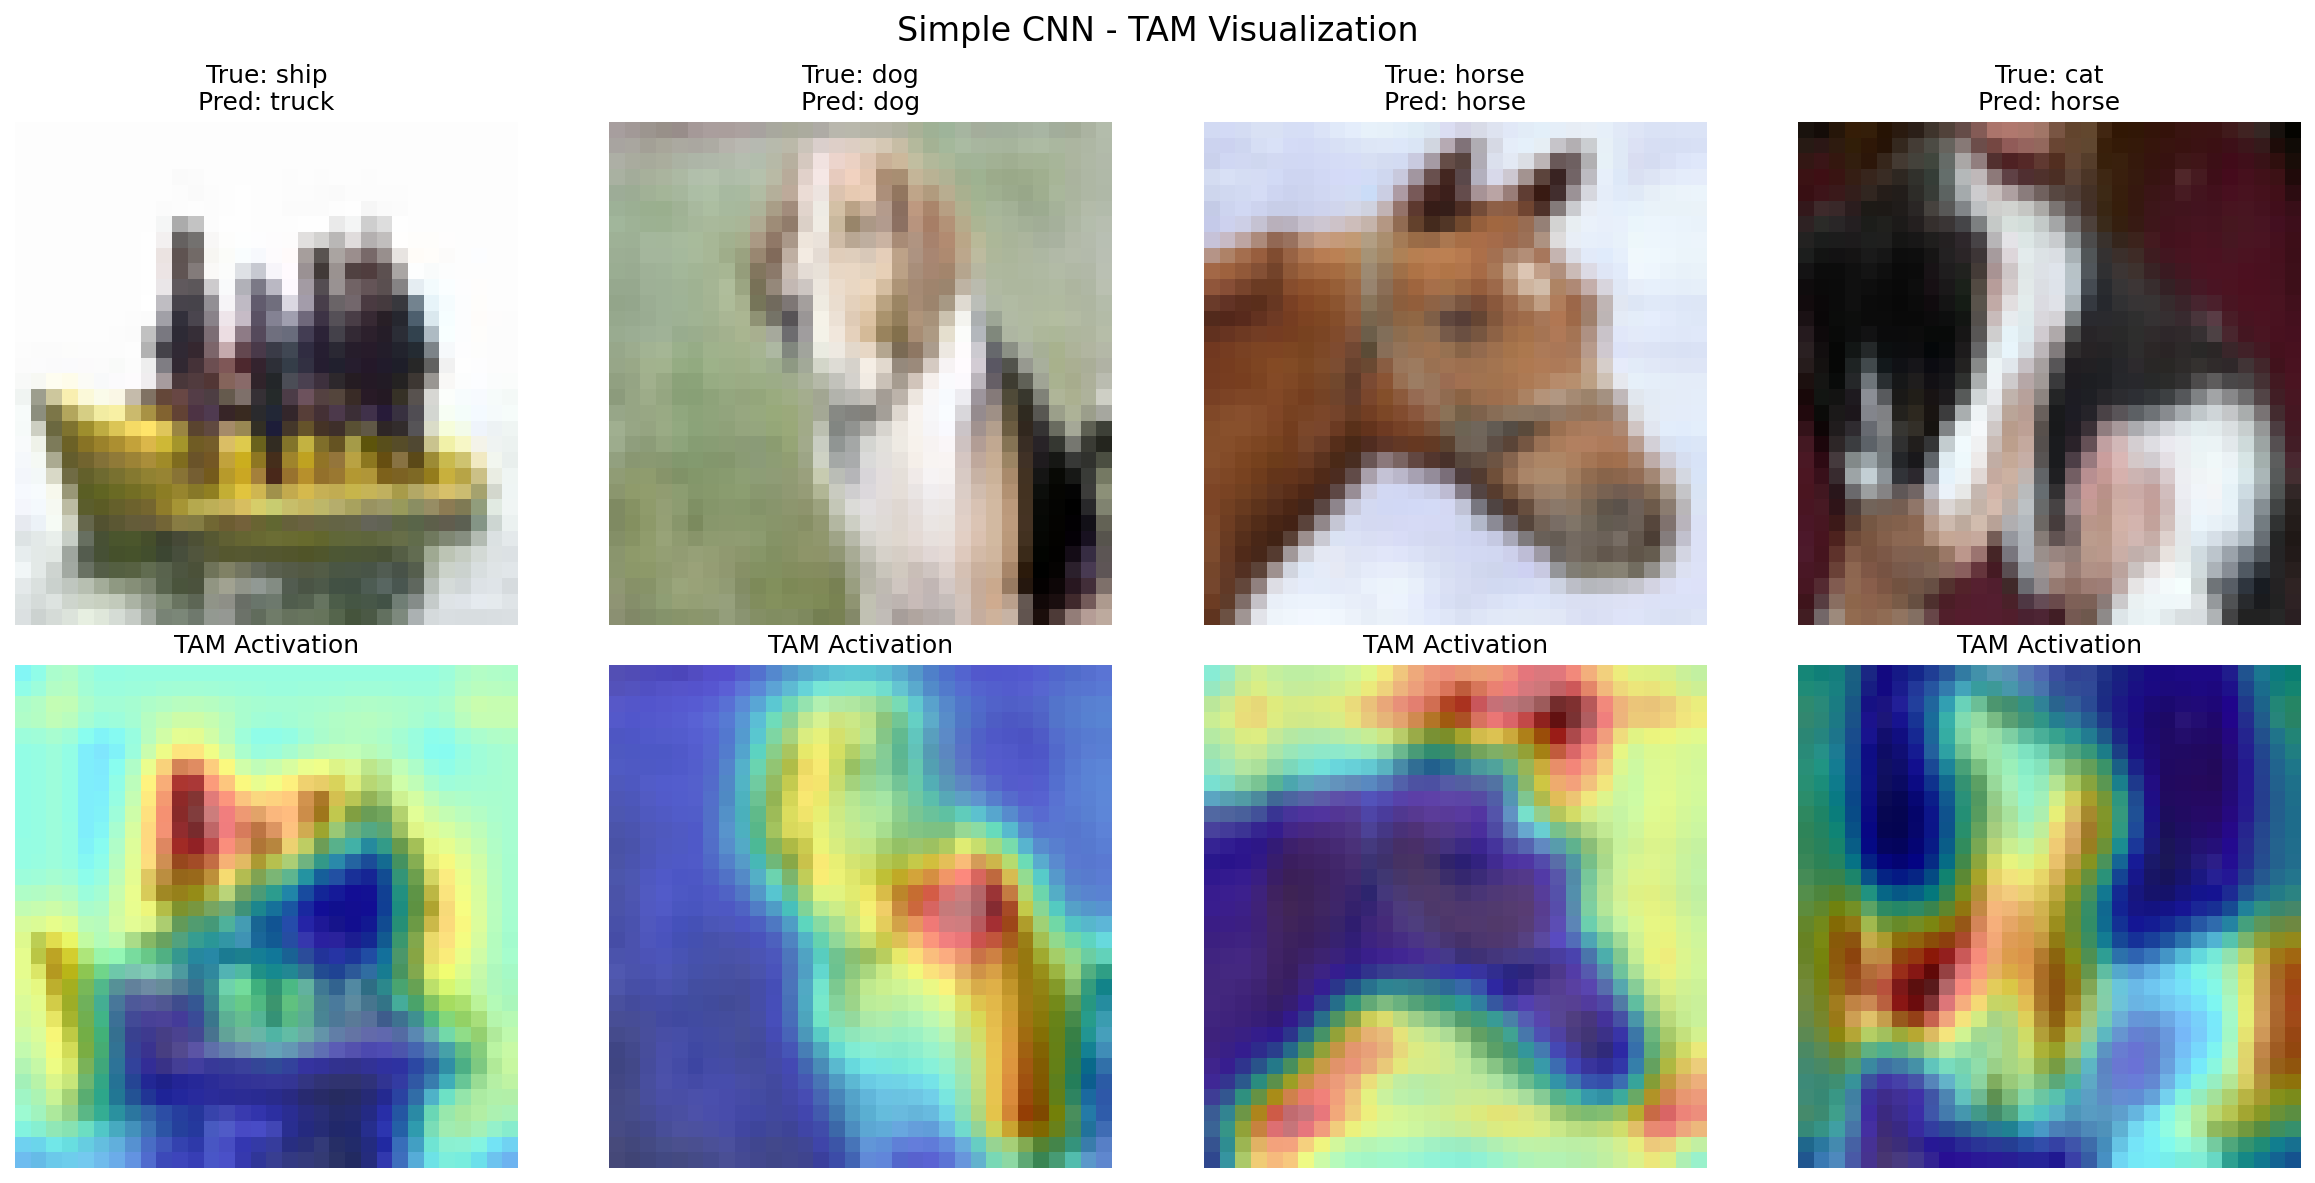

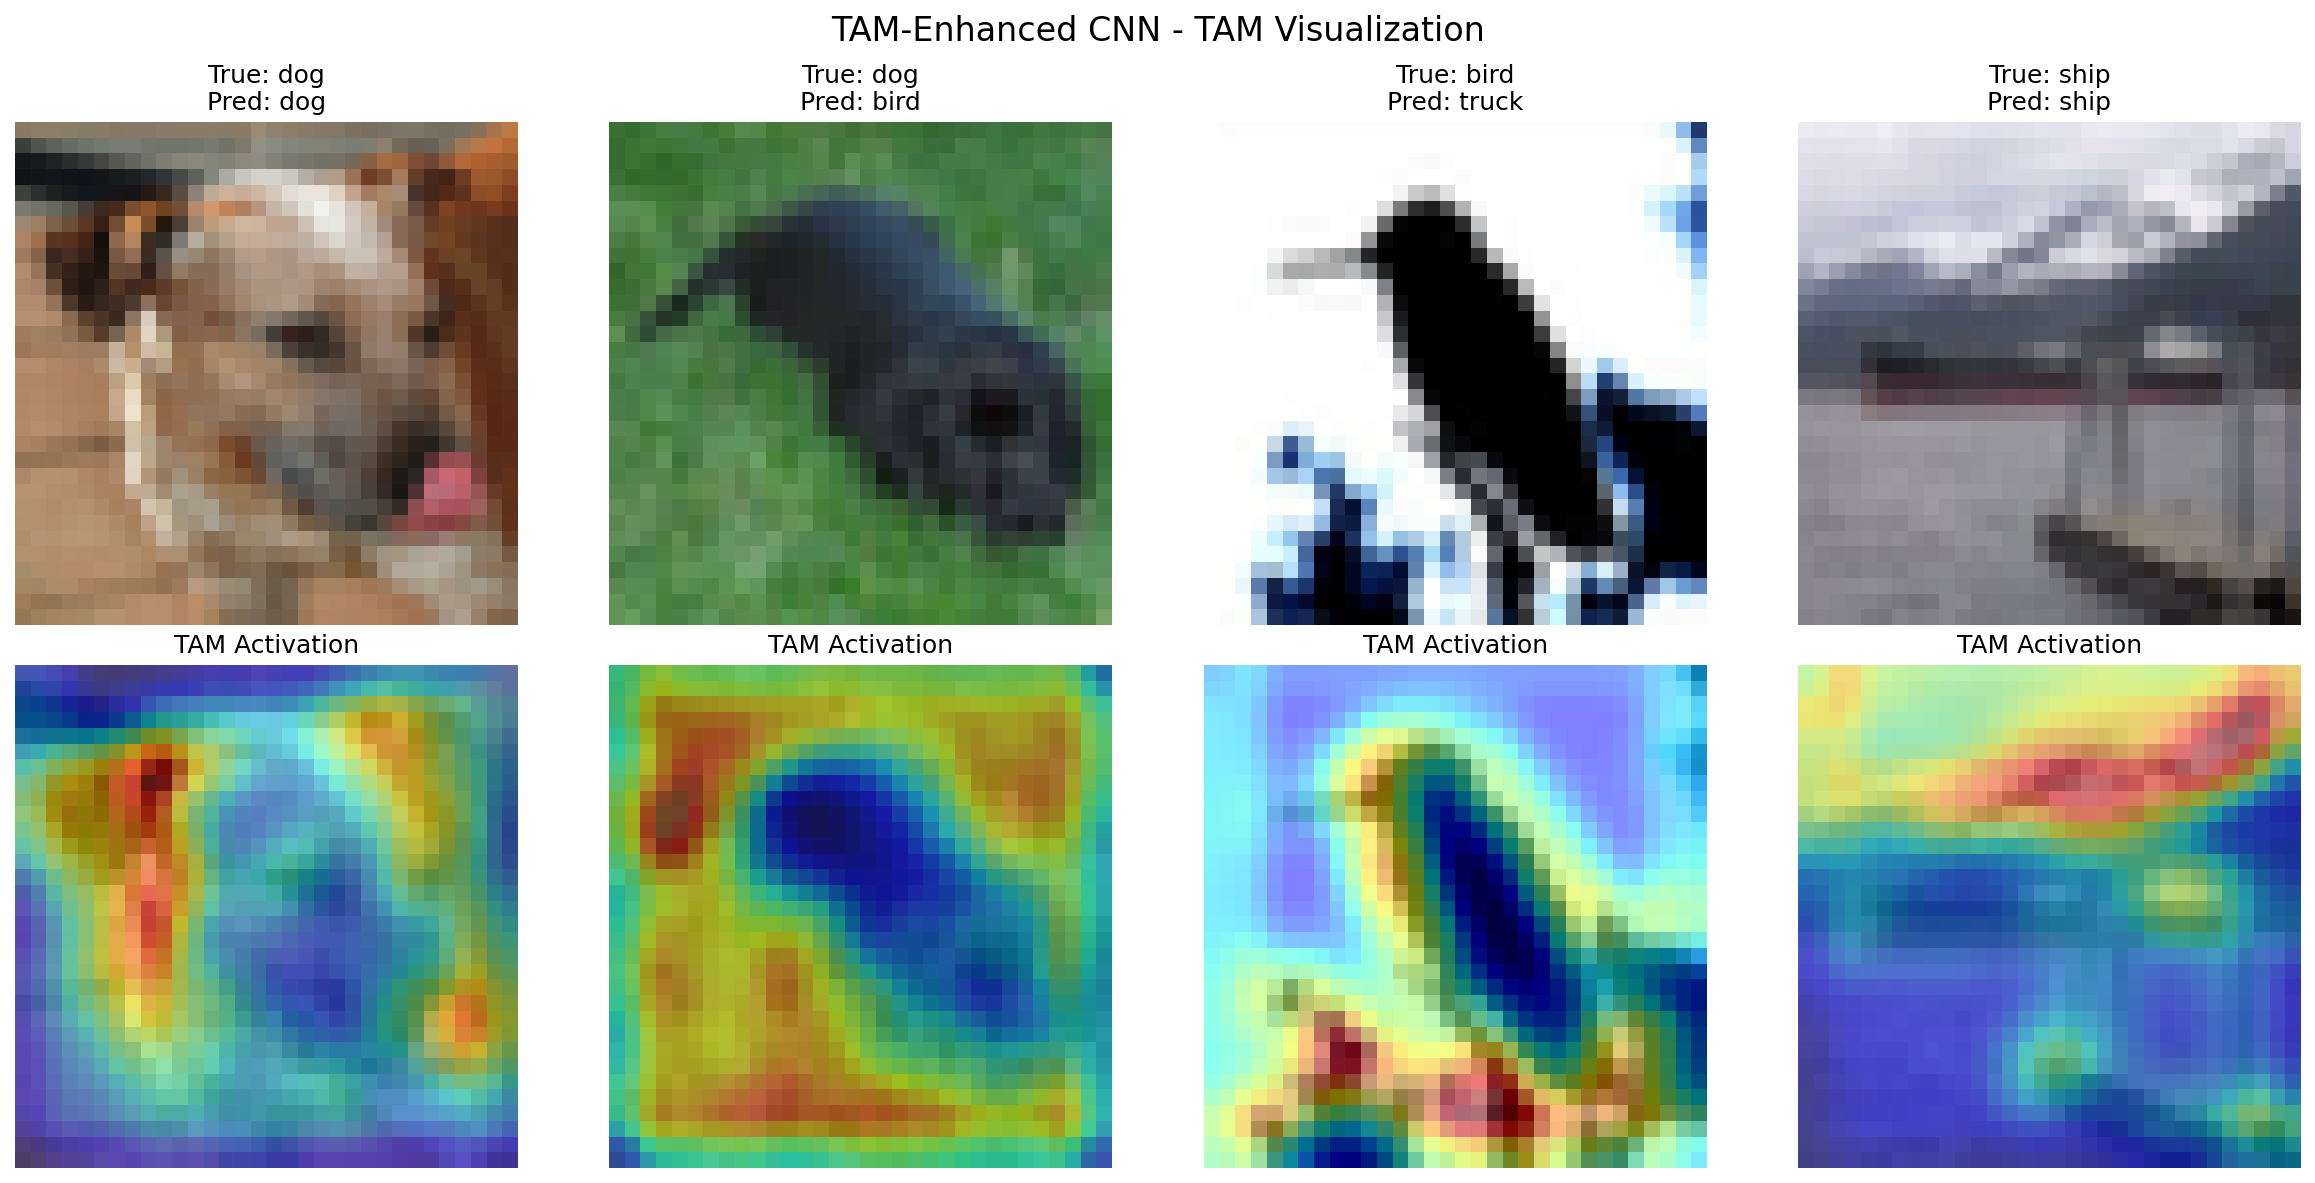

обычная cnn оказалась чуть лучше в плане метрик, при этом tam обучается чуть дольше